# Разведочный анализ датасета

Разведочный анализ данных (англ. exploratory data analysis, EDA) — анализ основных свойств данных, нахождение в них общих закономерностей, распределений и аномалий, построение начальных моделей, зачастую с использованием инструментов визуализации.

В данной лабораторной работе был проведён разведочный анализ датасета, содержащего данные о поездках на желтых такси.

Используемый датасет: https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data

## 1. Подготовка и импорты



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")

print("Path to dataset files:", path)

100%|██████████| 1.78G/1.78G [00:29<00:00, 65.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2


Дерево файлов выглядит следующим образом. К нам пришли данные за 2015-2016 годы, каждый датафрем весит по 1-2 гб. В рамках выполнения лабораторной работы будем использовать датафрейм yellow_tripdata_2016-03.csv

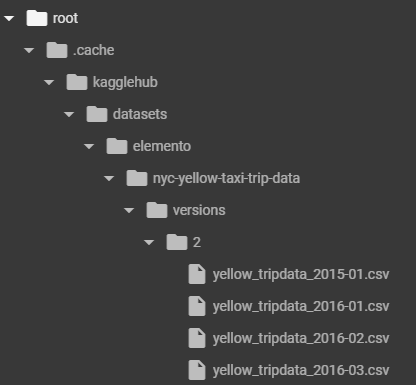

Слеудющие модули не относятся к PySpark, но будут использованы в процессе анализа датасета

In [124]:
# Импорт модулей, не связанныех с PySpark.
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# Это помогает автоматически распечатывать элементы без явного использования «печати».
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

Эти модули являются частью библиотеки PySpark и используются для взаимодействия с движком Spark

In [125]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
from pyspark.ml import Estimator, Transformer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

Настройка Spark и получение объекта сессии

In [126]:
# Initialize a spark session.
MAX_MEMORY = '9G'

conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

## 2. Обзор набора данных

Объявление схемы и чтение файла

In [127]:
filename_data = '/root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2/yellow_tripdata_2016-03.csv'

Используем spark для обработки больших данных. Если бы мы использовали pandas, то нам бы не хватило ОЗУ и вышла бы ошибка.

In [128]:
df = spark.read.option("header", True).option('delimiter', ',').csv(filename_data, inferSchema = True)
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
# определение типов признаков в датасете;
print('Обзор данных')
df.printSchema()
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор данных
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

Обзор столбцов


,Column Name,Data type
0,VendorID,int
1,tpep_pickup_datetime,timestamp
2,tpep_dropoff_datetime,timestamp
3,passenger_count,int
4,trip_distance,double
5,pickup_longitude,double
6,pickup_latitude,double
7,RatecodeID,int
8,store_and_fwd_flag,string
9,dropoff_longitude,double


Датасет состоит из следующих столбцов:

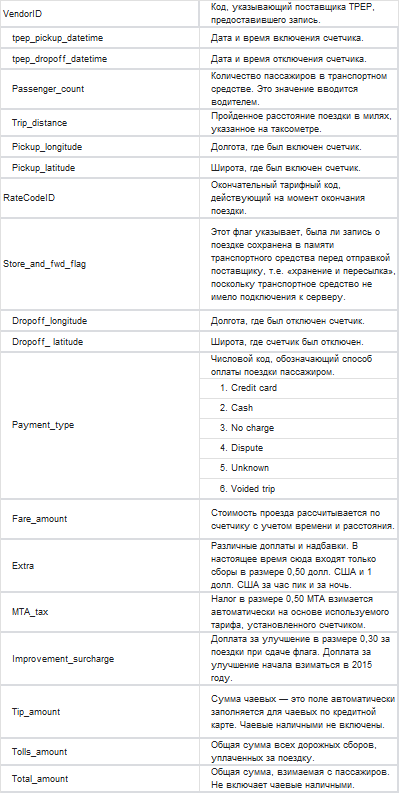

In [ ]:
df.limit(5).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-03-01,2016-03-01 00:07:55,1,2.50,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.00,0.3,12.35
1,1,2016-03-01,2016-03-01 00:11:06,1,2.90,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.00,0.3,15.35
2,2,2016-03-01,2016-03-01 00:31:06,2,19.98,-73.782021,40.644810,1,N,-73.974541,40.675770,1,54.5,0.5,0.5,8.00,0.00,0.3,63.80
3,2,2016-03-01,2016-03-01 00:00:00,3,10.78,-73.863419,40.769814,1,N,-73.969650,40.757767,1,31.5,0.0,0.5,3.78,5.54,0.3,41.62
4,2,2016-03-01,2016-03-01 00:00:00,5,30.43,-73.971741,40.792183,3,N,-74.177170,40.695053,1,98.0,0.0,0.0,0.00,15.50,0.3,113.80


Получим обзорные статистики по каждой из колонок

In [ ]:
print('Описание фрейма данных (только строковые и числовые столбцы):')
df.describe().toPandas()
# выполнение 3 мин. 44 сек.

Описание фрейма данных (только строковые и числовые столбцы):


,summary,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,count,12210952,12210952,12210952,12210952,12210952,12210952,12210952,12210952,12210952,12210952,12210952,12210952,12210952,12210952,12210952,12210952,12210952
1,mean,1.5306474057059598,1.659580022917132,6.131769762914482,-72.87132991979787,40.143488980644385,1.0403949667478833,None,-72.93678872569373,40.180495249545515,1.3409196924203781,12.795078448428898,0.34555996944382383,0.49763632270440494,1.792581815897803,0.31525542807806806,0.29971993501773414,16.04581967493267
2,stddev,0.4990598730813821,1.3121892188373814,6156.4826446949155,8.964107681848239,4.937995857941829,0.5807341657706823,None,8.69697399909999,4.7909399268384485,0.4902621290950896,134.09792335003755,0.45630689111090605,0.0486331851500267,2.5491241397467626,1.751526058995676,0.012306466039395534,134.3577728869804
3,min,1,0,0.0,-161.69866943359375,0.0,1,N,-161.69866943359375,0.0,1,-376.0,-58.5,-1.0,-20.0,-16.04,-0.3,-376.3
4,max,2,9,1.90726288E7,0.0,66.85681915283203,99,Y,0.0,50.7978630065918,4,429496.72,80.0,79.3,850.0,1410.32,0.3,429562.25


Пустых значений нет

In [ ]:
# подсчет общего кол-ва строк
print(f'Общее количество {df.count()} строк, печатаем несколько первых строк:')
df.limit(2).toPandas()

Общее количество 12210952 строк, печатаем несколько первых строк:


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-03-01,2016-03-01 00:07:55,1,2.5,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.0,0.3,12.35
1,1,2016-03-01,2016-03-01 00:11:06,1,2.9,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.0,0.3,15.35


**12.210.952** строки содержит текущий датасет

# **3. Обнаружение пропущенных значений и аномальных нулей.** <a class="anchor" id="3"></a>



После предварительного просмотра столбцов первое, что должны проверить, — это наличие в наборе данных какого-либо пропущенного значения.


In [ ]:
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор столбцов


,Column Name,Data type
0,VendorID,int
1,tpep_pickup_datetime,timestamp
2,tpep_dropoff_datetime,timestamp
3,passenger_count,int
4,trip_distance,double
5,pickup_longitude,double
6,pickup_latitude,double
7,RatecodeID,int
8,store_and_fwd_flag,string
9,dropoff_longitude,double


In [ ]:
# цикл для подсчета пропущенных и  нулевых значений
from pyspark.sql.functions import col
string_columns = ['store_and_fwd_flag']
numeric_columns = ['VendorID','RatecodeID', 'passenger_count']
double_columns = ['fare_amount', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                  'dropoff_latitude', 'extra', 'mta_tax', 'tip_amount',
                  'tolls_amount', 'improvement_surcharge', 'total_amount']
timestamp_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
missing_values = {}

for index, column in enumerate(df.columns):
    if column in string_columns:
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})
    if column in double_columns:
        missing_count = df.filter((col(column).isNull()) | (col(column) == 0) | isnan(col(column))).count()
        missing_values.update({column: missing_count})
    if column in timestamp_columns:
        missing_count = df.filter(col(column).isNull()).count()
        missing_values.update({column: missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df
# 9 min. 29 sec.

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,0,0,0,608,71126,182001,182001,0,0,171160,171160,3781,6154399,49420,4388626,11567061,2232,1267


Объяснение нулей:


*   passenger_count - таксисты сами отмечают кол-во пассажиров. могли забыть отметить, либо это отмененный заказ
*   trip_distance - заказ отменили, либо счетчик не считал
*   pickup_longitude	pickup_latitude dropoff_longitude - координаты с 0 не могут проходить по Нью-Йорку
*   fare_amount - стоимость по счетчику не заполнилась из-за отмены заказа либо потому что счетчик не считал
*   extra - доплата не всегда может быть, либо заказ не был выполнен
*   mta_tax	tip_amount	tolls_amount	improvement_surcharge	total_amount - заказ не был выполнен









В датасете нет пустых строк

Уберем некорректные координаты.

In [133]:
df = df.filter((col("pickup_longitude") < 0))
df = df.filter((col("pickup_latitude") > 0))
df = df.filter((col("dropoff_longitude") < 0))
df = df.filter((col("dropoff_latitude") > 0))

In [ ]:
df.limit(10).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,2.50,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.00,0.3,12.35
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,2.90,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.00,0.3,15.35
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,19.98,-73.782021,40.644810,1,N,-73.974541,40.675770,1,54.5,0.5,0.5,8.00,0.00,0.3,63.80
3,2,2016-03-01 00:00:00,2016-03-01 00:00:00,3,10.78,-73.863419,40.769814,1,N,-73.969650,40.757767,1,31.5,0.0,0.5,3.78,5.54,0.3,41.62
4,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,30.43,-73.971741,40.792183,3,N,-74.177170,40.695053,1,98.0,0.0,0.0,0.00,15.50,0.3,113.80
5,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,5.92,-74.017197,40.705383,1,N,-73.978073,40.755787,1,23.5,1.0,0.5,5.06,0.00,0.3,30.36
6,1,2016-03-01 00:00:01,2016-03-01 00:16:04,1,6.20,-73.788773,40.647758,1,N,-73.829208,40.712345,3,20.5,0.5,0.5,0.00,0.00,0.3,21.80
7,1,2016-03-01 00:00:01,2016-03-01 00:05:00,1,0.70,-73.958221,40.764641,1,N,-73.967896,40.762901,1,5.5,0.5,0.5,2.00,0.00,0.3,8.80
8,2,2016-03-01 00:00:01,2016-03-01 00:24:06,3,7.18,-73.985779,40.741192,1,N,-73.946350,40.797878,1,23.5,0.5,0.5,3.20,0.00,0.3,28.00
9,2,2016-03-01 00:00:01,2016-03-01 00:02:03,2,0.54,-73.988426,40.764160,1,N,-73.992393,40.758224,2,4.0,0.5,0.5,0.00,0.00,0.3,5.30


In [134]:
from pyspark.sql.functions import unix_timestamp
# Добавление нового столбца с продолжительностью поездки в минутах
df = df.withColumn(
    "trip_duration",
    ((unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime")))/ 60)
)

# Вывод результата
df.limit(10).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,2.50,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.00,0.3,12.35,7.916667
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,2.90,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.00,0.3,15.35,11.100000
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,19.98,-73.782021,40.644810,1,N,-73.974541,40.675770,1,54.5,0.5,0.5,8.00,0.00,0.3,63.80,31.100000
3,2,2016-03-01 00:00:00,2016-03-01 00:00:00,3,10.78,-73.863419,40.769814,1,N,-73.969650,40.757767,1,31.5,0.0,0.5,3.78,5.54,0.3,41.62,0.000000
4,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,30.43,-73.971741,40.792183,3,N,-74.177170,40.695053,1,98.0,0.0,0.0,0.00,15.50,0.3,113.80,0.000000
5,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,5.92,-74.017197,40.705383,1,N,-73.978073,40.755787,1,23.5,1.0,0.5,5.06,0.00,0.3,30.36,0.000000
6,1,2016-03-01 00:00:01,2016-03-01 00:16:04,1,6.20,-73.788773,40.647758,1,N,-73.829208,40.712345,3,20.5,0.5,0.5,0.00,0.00,0.3,21.80,16.050000
7,1,2016-03-01 00:00:01,2016-03-01 00:05:00,1,0.70,-73.958221,40.764641,1,N,-73.967896,40.762901,1,5.5,0.5,0.5,2.00,0.00,0.3,8.80,4.983333
8,2,2016-03-01 00:00:01,2016-03-01 00:24:06,3,7.18,-73.985779,40.741192,1,N,-73.946350,40.797878,1,23.5,0.5,0.5,3.20,0.00,0.3,28.00,24.083333
9,2,2016-03-01 00:00:01,2016-03-01 00:02:03,2,0.54,-73.988426,40.764160,1,N,-73.992393,40.758224,2,4.0,0.5,0.5,0.00,0.00,0.3,5.30,2.033333


Отфильтруем нули во времени в пути

In [135]:
df = df.filter((col("trip_duration") > 0))
df.limit(10).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,2.50,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.0,0.3,12.35,7.916667
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,2.90,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.0,0.3,15.35,11.100000
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,19.98,-73.782021,40.644810,1,N,-73.974541,40.675770,1,54.5,0.5,0.5,8.00,0.0,0.3,63.80,31.100000
3,1,2016-03-01 00:00:01,2016-03-01 00:16:04,1,6.20,-73.788773,40.647758,1,N,-73.829208,40.712345,3,20.5,0.5,0.5,0.00,0.0,0.3,21.80,16.050000
4,1,2016-03-01 00:00:01,2016-03-01 00:05:00,1,0.70,-73.958221,40.764641,1,N,-73.967896,40.762901,1,5.5,0.5,0.5,2.00,0.0,0.3,8.80,4.983333
5,2,2016-03-01 00:00:01,2016-03-01 00:24:06,3,7.18,-73.985779,40.741192,1,N,-73.946350,40.797878,1,23.5,0.5,0.5,3.20,0.0,0.3,28.00,24.083333
6,2,2016-03-01 00:00:01,2016-03-01 00:02:03,2,0.54,-73.988426,40.764160,1,N,-73.992393,40.758224,2,4.0,0.5,0.5,0.00,0.0,0.3,5.30,2.033333
7,1,2016-03-01 00:00:02,2016-03-01 00:07:49,1,1.70,-73.969818,40.797428,1,N,-73.943771,40.796200,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30,7.783333
8,1,2016-03-01 00:00:02,2016-03-01 00:03:05,1,1.10,-73.953804,40.788128,1,N,-73.971550,40.795238,1,5.5,0.5,0.5,2.20,0.0,0.3,9.00,3.050000
9,2,2016-03-01 00:00:02,2016-03-01 00:09:32,1,2.10,-73.976089,40.752171,1,N,-73.987450,40.770782,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,9.500000


Проверим выбросы по дистанции. Выберем данные, где дистанция больше 500 миль, так как 500 миль это примерно 800 км. Их можно проехать примерно за 8 часов, но кто ездит на такси 8 часов?

In [ ]:
df.where(df.trip_distance > 500).limit(10).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
0,1,2016-03-01 15:27:57,2016-03-01 15:51:26,1,5000000.0,-73.870735,40.773697,1,N,-73.985825,40.749889,1,25.00,0.00,0.50,13.66,5.54,0.3,45.00,23.483333
1,1,2016-03-04 14:46:57,2016-03-04 15:44:23,1,510.7,-73.873039,40.774101,1,N,-74.040596,40.624191,1,47.50,0.00,0.50,9.66,0.00,0.3,57.96,57.433333
2,1,2016-03-05 14:04:07,2016-03-05 14:10:47,1,3008.3,-74.009026,40.710903,1,N,-73.997574,40.719444,2,6.00,0.00,0.50,0.00,0.00,0.3,6.80,6.666667
3,1,2016-03-14 17:47:11,2016-03-14 17:51:20,1,1663428.0,-73.945099,40.751377,1,N,-73.945099,40.751377,2,4.50,1.00,0.50,0.00,0.00,0.3,6.30,4.150000
4,1,2016-03-14 08:45:54,2016-03-14 08:55:07,2,452310.8,-73.964699,40.803417,2,N,-73.961243,40.796741,3,2.50,0.00,0.50,0.00,0.00,0.3,3.30,9.216667
5,1,2016-03-14 13:30:11,2016-03-14 14:00:30,2,300833.1,-73.994507,40.742775,1,N,-73.971497,40.765404,2,18.50,0.00,0.50,0.00,0.00,0.3,19.30,30.316667
6,1,2016-03-16 01:10:28,2016-03-16 01:35:36,1,800000.2,-73.991356,40.727306,1,N,-73.988716,40.777828,1,20.00,0.50,0.50,5.32,0.00,0.3,26.62,25.133333
7,1,2016-03-17 16:16:28,2016-03-17 16:30:25,1,318000.0,-73.992355,40.754440,1,N,-73.982231,40.759186,1,9.50,1.00,0.50,0.00,0.00,0.3,11.30,13.950000
8,1,2016-03-20 01:34:23,2016-03-20 01:40:03,1,308228.5,-73.981766,40.766449,1,N,-73.979591,40.755024,2,2.50,0.50,0.50,0.00,0.00,0.3,3.80,5.666667
9,1,2016-03-20 11:44:34,2016-03-20 12:03:29,2,131091.4,-73.940979,40.819290,2,N,-73.970802,40.751713,3,126348.88,16.38,1.32,0.00,0.00,0.0,126366.58,18.916667


5000000 миль невозможно проехать за 20 минут, так же как и все последующие расстояния из полученной таблицы. Вероятно, это тестовые данные, которые остались в базе данных компании.

Для удаления подобных выбросов, воспользуемся межквартильным растоянием (размахом).

Подход IQR устойчив к выбросам, так как использует медиану и квартильные значения.

In [136]:
# Вычисляем Q1, Q3 и IQR
q1, q3 = df.approxQuantile("trip_distance", [0.25, 0.75], 0.05)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
#lower_bound: минимальная граница, ниже которой значения считаются выбросами
#upper_bound: максимальная граница, выше которой значения считаются выбросами

print(f"Q1: {q1}, Q3: {q3}, IQR: {iqr}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

df = df.filter((col("trip_distance") >= lower_bound) & (col("trip_distance") <= upper_bound))

df.limit(10).toPandas()

Q1: 1.0, Q3: 3.07, IQR: 2.07, Lower Bound: -2.1049999999999995, Upper Bound: 6.174999999999999


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,2.50,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.0,0.3,12.35,7.916667
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,2.90,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.0,0.3,15.35,11.100000
2,1,2016-03-01 00:00:01,2016-03-01 00:05:00,1,0.70,-73.958221,40.764641,1,N,-73.967896,40.762901,1,5.5,0.5,0.5,2.00,0.0,0.3,8.80,4.983333
3,2,2016-03-01 00:00:01,2016-03-01 00:02:03,2,0.54,-73.988426,40.764160,1,N,-73.992393,40.758224,2,4.0,0.5,0.5,0.00,0.0,0.3,5.30,2.033333
4,1,2016-03-01 00:00:02,2016-03-01 00:07:49,1,1.70,-73.969818,40.797428,1,N,-73.943771,40.796200,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30,7.783333
5,1,2016-03-01 00:00:02,2016-03-01 00:03:05,1,1.10,-73.953804,40.788128,1,N,-73.971550,40.795238,1,5.5,0.5,0.5,2.20,0.0,0.3,9.00,3.050000
6,2,2016-03-01 00:00:02,2016-03-01 00:09:32,1,2.10,-73.976089,40.752171,1,N,-73.987450,40.770782,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,9.500000
7,2,2016-03-01 00:00:02,2016-03-01 00:08:24,1,2.00,-74.006729,40.730717,1,N,-74.017044,40.709366,1,8.5,0.5,0.5,2.00,0.0,0.3,11.80,8.366667
8,1,2016-03-01 00:00:03,2016-03-01 00:09:23,1,3.20,-74.006615,40.716621,1,N,-73.990105,40.756050,2,11.0,0.5,0.5,0.00,0.0,0.3,12.30,9.333333
9,2,2016-03-01 00:00:03,2016-03-01 00:08:34,1,1.59,-73.982269,40.770618,1,N,-73.968742,40.755039,1,8.0,0.5,0.5,1.86,0.0,0.3,11.16,8.516667


Проверим большое время в пути. Оказывается, что здесь также имеются выбросы, так как за сутки и больше была преодолена небольшая дистанция.

In [ ]:
df.where(df.trip_duration > 300).limit(10).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
0,2,2016-03-10 07:12:14,2016-03-11 06:37:30,1,2.77,-74.005104,40.718864,1,N,-73.984100,40.754967,1,10.0,0.0,0.5,2.16,0.0,0.3,12.96,1405.266667
1,2,2016-03-10 07:19:46,2016-03-11 07:10:25,6,2.30,-73.986877,40.766460,1,N,-73.993744,40.741489,1,11.0,0.0,0.5,1.77,0.0,0.3,13.57,1430.650000
2,2,2016-03-10 07:20:36,2016-03-11 00:00:00,3,0.86,-73.986481,40.768490,1,N,-73.973831,40.764484,1,5.0,0.0,0.5,1.16,0.0,0.3,6.96,999.400000
3,2,2016-03-10 07:23:16,2016-03-11 07:03:23,1,5.45,-73.954681,40.764004,1,N,-73.997231,40.714165,1,18.5,0.0,0.5,2.90,0.0,0.3,22.20,1420.116667
4,2,2016-03-10 07:25:53,2016-03-11 06:47:37,1,2.72,-73.945900,40.777946,1,N,-73.979813,40.765919,1,14.0,0.0,0.5,2.96,0.0,0.3,17.76,1401.733333
5,2,2016-03-10 07:33:03,2016-03-11 00:00:00,2,0.97,-73.951736,40.773666,1,N,-73.949982,40.784672,1,5.5,0.0,0.5,0.94,0.0,0.3,7.24,986.950000
6,2,2016-03-10 07:37:17,2016-03-11 07:24:43,1,2.14,-74.015221,40.709358,1,N,-73.995789,40.724491,1,10.0,0.0,0.5,0.00,0.0,0.3,10.80,1427.433333
7,2,2016-03-10 07:39:53,2016-03-11 07:32:58,2,0.98,-73.964539,40.763878,1,N,-73.952629,40.768353,1,7.5,0.0,0.5,0.83,0.0,0.3,9.13,1433.083333
8,2,2016-03-10 07:40:22,2016-03-11 07:31:22,5,1.35,-74.008499,40.705753,1,N,-74.015488,40.711681,1,7.5,0.0,0.5,1.24,0.0,0.3,9.54,1431.000000
9,2,2016-03-10 07:41:14,2016-03-11 07:40:25,1,0.00,-73.776344,40.645805,2,N,-73.776360,40.645805,1,52.0,0.0,0.5,13.20,0.0,0.3,66.00,1439.183333


In [137]:
# Вычисляем Q1, Q3 и IQR
q1, q3 = df.approxQuantile("trip_duration", [0.25, 0.75], 0.05)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
#lower_bound: минимальная граница, ниже которой значения считаются выбросами
#upper_bound: максимальная граница, выше которой значения считаются выбросами

print(f"Q1: {q1}, Q3: {q3}, IQR: {iqr}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

df = df.filter((col("trip_duration") >= lower_bound) & (col("trip_duration") <= upper_bound))

df.limit(10).toPandas()

Q1: 5.866666666666666, Q3: 14.55, IQR: 8.683333333333334, Lower Bound: -7.158333333333334, Upper Bound: 27.575000000000003


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,2.50,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.0,0.3,12.35,7.916667
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,2.90,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.0,0.3,15.35,11.100000
2,1,2016-03-01 00:00:01,2016-03-01 00:05:00,1,0.70,-73.958221,40.764641,1,N,-73.967896,40.762901,1,5.5,0.5,0.5,2.00,0.0,0.3,8.80,4.983333
3,2,2016-03-01 00:00:01,2016-03-01 00:02:03,2,0.54,-73.988426,40.764160,1,N,-73.992393,40.758224,2,4.0,0.5,0.5,0.00,0.0,0.3,5.30,2.033333
4,1,2016-03-01 00:00:02,2016-03-01 00:07:49,1,1.70,-73.969818,40.797428,1,N,-73.943771,40.796200,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30,7.783333
5,1,2016-03-01 00:00:02,2016-03-01 00:03:05,1,1.10,-73.953804,40.788128,1,N,-73.971550,40.795238,1,5.5,0.5,0.5,2.20,0.0,0.3,9.00,3.050000
6,2,2016-03-01 00:00:02,2016-03-01 00:09:32,1,2.10,-73.976089,40.752171,1,N,-73.987450,40.770782,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,9.500000
7,2,2016-03-01 00:00:02,2016-03-01 00:08:24,1,2.00,-74.006729,40.730717,1,N,-74.017044,40.709366,1,8.5,0.5,0.5,2.00,0.0,0.3,11.80,8.366667
8,1,2016-03-01 00:00:03,2016-03-01 00:09:23,1,3.20,-74.006615,40.716621,1,N,-73.990105,40.756050,2,11.0,0.5,0.5,0.00,0.0,0.3,12.30,9.333333
9,2,2016-03-01 00:00:03,2016-03-01 00:08:34,1,1.59,-73.982269,40.770618,1,N,-73.968742,40.755039,1,8.0,0.5,0.5,1.86,0.0,0.3,11.16,8.516667


In [ ]:
df.select('trip_duration', 'trip_distance').describe().toPandas()

,summary,trip_duration,trip_distance
0,count,10359468,10359468
1,mean,10.643924864996148,1.826364137617898
2,stddev,5.906707074823942,1.2231563935655043
3,min,0.016666666666666666,0.0
4,max,27.566666666666666,6.17


Проверим нулевые значения дистанции и сопоставим со временем в пути. Чаще всего время в пути даже не равно минуте. Это значит, что по какой-то причине заказ был завершен досрочно.

In [ ]:
df.where(df.trip_distance == 0.0).limit(10).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
0,2,2016-03-10 07:08:26,2016-03-10 07:08:29,5,0.0,-73.902107,40.764065,1,N,-73.902092,40.764122,2,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.050000
1,2,2016-03-10 07:11:55,2016-03-10 07:13:17,5,0.0,-73.902115,40.764221,1,N,-73.902077,40.764233,2,3.0,0.0,0.5,0.00,0.00,0.3,3.80,1.366667
2,2,2016-03-10 07:13:06,2016-03-10 07:13:10,1,0.0,-73.979973,40.764660,1,N,-73.979950,40.764629,1,2.5,0.0,0.5,5.00,0.00,0.3,8.30,0.066667
3,2,2016-03-10 07:14:39,2016-03-10 07:16:42,1,0.0,-73.901962,40.763931,1,N,-73.901970,40.763939,2,0.0,0.0,0.0,0.00,0.00,0.0,0.00,2.050000
4,2,2016-03-10 07:20:09,2016-03-10 07:27:54,5,0.0,-73.978363,40.748260,1,N,-73.974670,40.740261,1,6.0,0.0,0.5,1.36,0.00,0.3,8.16,7.750000
5,2,2016-03-10 07:20:38,2016-03-10 07:21:03,1,0.0,-73.964973,40.759930,1,N,-73.964973,40.759930,2,2.5,0.0,0.5,0.00,0.00,0.3,3.30,0.416667
6,2,2016-03-10 07:22:19,2016-03-10 07:30:43,1,0.0,-73.994545,40.750671,1,N,-73.977463,40.754978,2,6.5,0.0,0.5,0.00,0.00,0.3,7.30,8.400000
7,2,2016-03-10 07:22:27,2016-03-10 07:23:51,1,0.0,-73.901932,40.763931,1,N,-73.901947,40.763924,2,0.0,0.0,0.0,0.00,0.00,0.0,0.00,1.400000
8,2,2016-03-10 07:25:53,2016-03-10 07:29:45,6,0.0,-73.983902,40.740009,1,N,-73.983871,40.740002,2,4.0,0.0,0.5,0.00,0.00,0.3,4.80,3.866667
9,2,2016-03-10 07:26:10,2016-03-10 07:26:31,1,0.0,-73.970467,40.753075,2,N,-73.970467,40.753029,2,52.0,0.0,0.5,0.00,5.54,0.3,58.34,0.350000


In [ ]:
# Статистические показатели
df.describe().toPandas()

,summary,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
0,count,10359468,10359468,10359468,10359468,10359468,10359468,10359468,10359468,10359468,10359468,10359468,10359468,10359468,10359468,10359468,10359468,10359468,10359468
1,mean,1.5320269342016404,1.6563341862728858,1.826364137617898,-73.98021244981574,40.752853497891834,1.0090969922393698,None,-73.97827539205062,40.75334071690214,1.3482154682074408,9.46213061327084,0.33593177275126485,0.4987777084691993,1.3270901835881534,0.022464726953161394,0.2997385579998568,11.94612905695475,10.643924864996148
2,stddev,0.49897324529392256,1.3122662887017282,1.2231563935655043,0.09861891946847885,0.03311637704672658,0.2715727127912687,None,0.0978586013247346,0.03381955000998313,0.4919340647474569,5.139734135340534,0.3808005577864706,0.02854786719730844,1.5513975752207414,0.6155703028947218,0.012218456679640654,6.040761408329715,5.906707074823942
3,min,1,0,0.0,-161.69866943359375,17.261701583862305,1,N,-161.69866943359375,17.261701583862305,1,-376.0,-4.5,-1.0,-13.2,-16.04,-0.3,-376.3,0.016666666666666666
4,max,2,9,6.17,-7.016666889190674,66.85681915283203,99,Y,-0.1166670024394989,50.7978630065918,4,1000.0,51.0,3.0,850.0,812.5,0.3,1273.3,27.566666666666666


## Корреляции

Определим корреляции между значениями в датасете

In [ ]:
# Преобразуем данные в формат VectorAssembler
numeric_columns = [col for col, dtype in df.dtypes if dtype in ('int', 'double', 'float')]
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col).head()[0]
corr_matrix_df = pd.DataFrame(data=matrix, columns = df.columns, index=df.columns)


In [ ]:
import numpy as np
matrix_array = np.array(matrix.toArray())  # Конвертируем матрицу из формата Spark в Numpy
corr_matrix_df1 = pd.DataFrame(data=matrix_array, columns=numeric_columns, index=numeric_columns)
display(corr_matrix_df1)

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
VendorID,1.000000,0.293704,0.018174,0.000407,0.004904,-0.010652,-0.000348,0.004642,-0.014364,-0.001062,-0.002958,0.004645,-0.000049,-0.001944,-0.019621,-0.001319,0.004226
passenger_count,0.293704,1.000000,0.012692,-0.001521,-0.003176,-0.008447,-0.001767,-0.002351,0.012072,0.005484,0.000912,0.004969,-0.009954,-0.002041,-0.003848,0.001975,0.013423
trip_distance,0.018174,0.012692,1.000000,-0.001512,-0.074557,-0.020258,0.031433,-0.063973,-0.086529,0.708399,0.047744,0.034788,0.311321,0.045855,0.027151,0.690591,0.733310
pickup_longitude,0.000407,-0.001521,-0.001512,1.000000,0.233853,0.005753,0.764134,0.195019,0.016719,0.001259,-0.006009,-0.003664,-0.008832,0.002082,0.001155,-0.001379,-0.016296
pickup_latitude,0.004904,-0.003176,-0.074557,0.233853,1.000000,-0.007477,0.195724,0.619819,0.033905,-0.062176,-0.038130,0.010862,-0.050187,-0.010534,0.012158,-0.069192,-0.056201
RatecodeID,-0.010652,-0.008447,-0.020258,0.005753,-0.007477,1.000000,0.003185,-0.007629,0.009364,0.223789,-0.018278,-0.394548,0.081522,0.115647,-0.019496,0.220073,-0.035487
dropoff_longitude,-0.000348,-0.001767,0.031433,0.764134,0.195724,0.003185,1.000000,0.186593,0.016216,0.018442,0.006355,-0.001242,-0.001270,0.004055,0.001561,0.016176,-0.003033
dropoff_latitude,0.004642,-0.002351,-0.063973,0.195019,0.619819,-0.007629,0.186593,1.000000,0.035792,-0.068337,-0.019696,0.011015,-0.057598,-0.017152,0.012108,-0.075849,-0.077054
payment_type,-0.014364,0.012072,-0.086529,0.016719,0.033905,0.009364,0.016216,0.035792,1.000000,-0.071718,-0.024636,-0.063933,-0.605503,-0.005465,-0.077647,-0.219097,-0.077513
fare_amount,-0.001062,0.005484,0.708399,0.001259,-0.062176,0.223789,0.018442,-0.068337,-0.071718,1.000000,0.014659,-0.128962,0.371776,0.152383,0.069112,0.962306,0.711423


<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix')

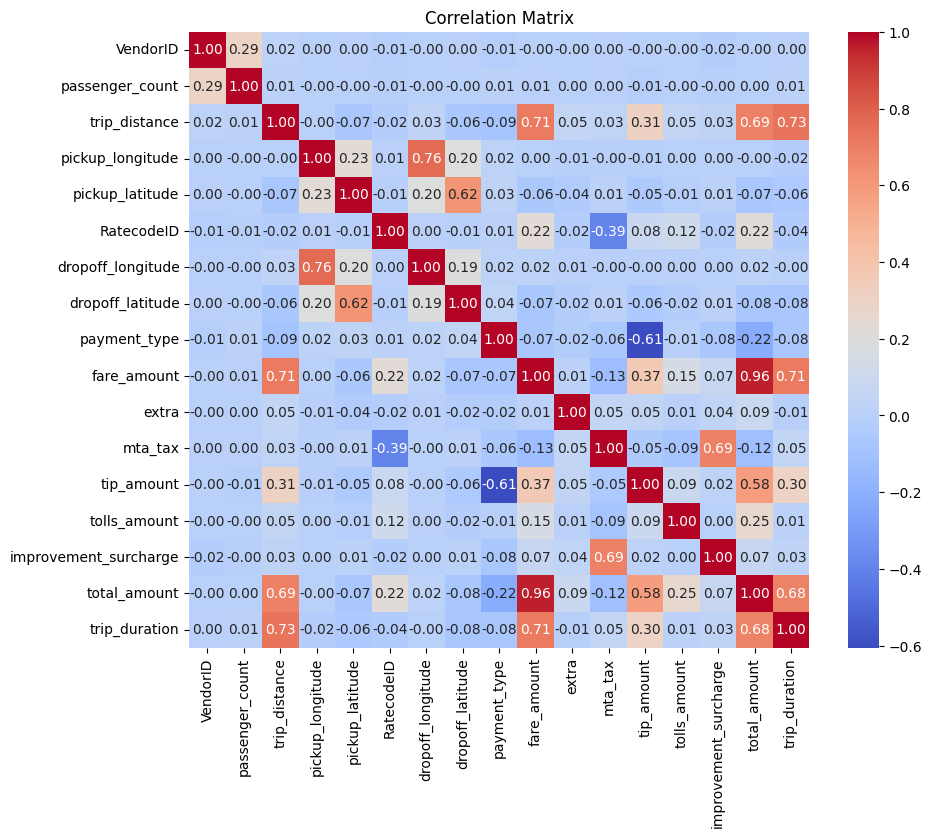

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_df1, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

По матрице корреляций видно, что координаты начала поездки коррелируют с коордаинатами конца поездки. Длительность и расстояние c ними практически не коррелируют. При этом между собой расстояние и длительность имеют высокую корреляцию. Также стоимость поездки коррелирует с расстоянием и временем поездки. Количество чаевых также в некоторой степени коррелирует с расстоянием и длительностью поездки.

## Графики и диаграммы



---

Построим гистограмму распределения числа поездок по длительности

Зададим новый столбец, включающих только дату поездки (берем конечную дату), в новую таблицу для того, чтобы удобно составлять диаграммы. Заодно отфильтруем даты только на март.

In [138]:
import pyspark.sql.functions as F
data_df = df.withColumn("date_of_trip", F.to_date("tpep_dropoff_datetime"))
data_df = data_df.filter((col("date_of_trip") < '2016-04-01'))
data_df.limit(10).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,date_of_trip
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,2.50,-73.976746,40.765152,1,N,-74.004265,...,1,9.0,0.5,0.5,2.05,0.0,0.3,12.35,7.916667,2016-03-01
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,2.90,-73.983482,40.767925,1,N,-74.005943,...,1,11.0,0.5,0.5,3.05,0.0,0.3,15.35,11.100000,2016-03-01
2,1,2016-03-01 00:00:01,2016-03-01 00:05:00,1,0.70,-73.958221,40.764641,1,N,-73.967896,...,1,5.5,0.5,0.5,2.00,0.0,0.3,8.80,4.983333,2016-03-01
3,2,2016-03-01 00:00:01,2016-03-01 00:02:03,2,0.54,-73.988426,40.764160,1,N,-73.992393,...,2,4.0,0.5,0.5,0.00,0.0,0.3,5.30,2.033333,2016-03-01
4,1,2016-03-01 00:00:02,2016-03-01 00:07:49,1,1.70,-73.969818,40.797428,1,N,-73.943771,...,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30,7.783333,2016-03-01
5,1,2016-03-01 00:00:02,2016-03-01 00:03:05,1,1.10,-73.953804,40.788128,1,N,-73.971550,...,1,5.5,0.5,0.5,2.20,0.0,0.3,9.00,3.050000,2016-03-01
6,2,2016-03-01 00:00:02,2016-03-01 00:09:32,1,2.10,-73.976089,40.752171,1,N,-73.987450,...,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,9.500000,2016-03-01
7,2,2016-03-01 00:00:02,2016-03-01 00:08:24,1,2.00,-74.006729,40.730717,1,N,-74.017044,...,1,8.5,0.5,0.5,2.00,0.0,0.3,11.80,8.366667,2016-03-01
8,1,2016-03-01 00:00:03,2016-03-01 00:09:23,1,3.20,-74.006615,40.716621,1,N,-73.990105,...,2,11.0,0.5,0.5,0.00,0.0,0.3,12.30,9.333333,2016-03-01
9,2,2016-03-01 00:00:03,2016-03-01 00:08:34,1,1.59,-73.982269,40.770618,1,N,-73.968742,...,1,8.0,0.5,0.5,1.86,0.0,0.3,11.16,8.516667,2016-03-01


Сгруппируем данные по дате и вычислим среднюю цену.

In [ ]:
grouped = data_df.groupBy('date_of_trip')
grouped.mean('total_amount').show()

+------------+------------------+
|date_of_trip| avg(total_amount)|
+------------+------------------+
|  2016-03-01|11.923701891972213|
|  2016-03-02|11.944381965085961|
|  2016-03-10|12.223018283546219|
|  2016-03-03|12.062151257253676|
|  2016-03-04| 11.96849594770758|
|  2016-03-06|11.712599626697594|
|  2016-03-05|11.795934671569881|
|  2016-03-25|11.970556406368354|
|  2016-03-11|12.102893578307969|
|  2016-03-14|11.599986280863481|
|  2016-03-15|12.048679034087625|
|  2016-03-13|11.711414244523803|
|  2016-03-07|11.818553607488523|
|  2016-03-12|11.942269996881224|
|  2016-03-08|12.025142647622307|
|  2016-03-09| 12.12935456090633|
|  2016-03-16|12.183810513828726|
|  2016-03-17|12.147091361262058|
|  2016-03-19| 11.81181970759564|
|  2016-03-18|12.135725417374974|
+------------+------------------+
only showing top 20 rows



Создадим линейный график для просмотра длительности поездки по дате

In [ ]:
dur_hist = (
    data_df
    #.withColumn('hist', (df['trip_duration'] / 1000).astype(IntegerType()))
    .groupBy('date_of_trip').mean('trip_duration').orderBy('date_of_trip')
    #.withColumnRenamed('hist', 'trip_duration')
    .toPandas()
)

Можем заметить некую цикличность в среднем времени в пути, это связано с тем, что по выходным почти нет пробок.


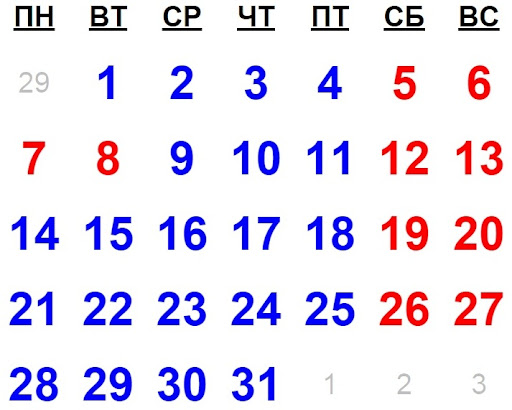

(array([16860., 16863., 16866., 16869., 16872., 16875., 16878., 16881.,
        16884., 16887., 16890.]),
 [Text(16860.0, 0, '2016-02-29'),
  Text(16863.0, 0, '2016-03-03'),
  Text(16866.0, 0, '2016-03-06'),
  Text(16869.0, 0, '2016-03-09'),
  Text(16872.0, 0, '2016-03-12'),
  Text(16875.0, 0, '2016-03-15'),
  Text(16878.0, 0, '2016-03-18'),
  Text(16881.0, 0, '2016-03-21'),
  Text(16884.0, 0, '2016-03-24'),
  Text(16887.0, 0, '2016-03-27'),
  Text(16890.0, 0, '2016-03-30')])

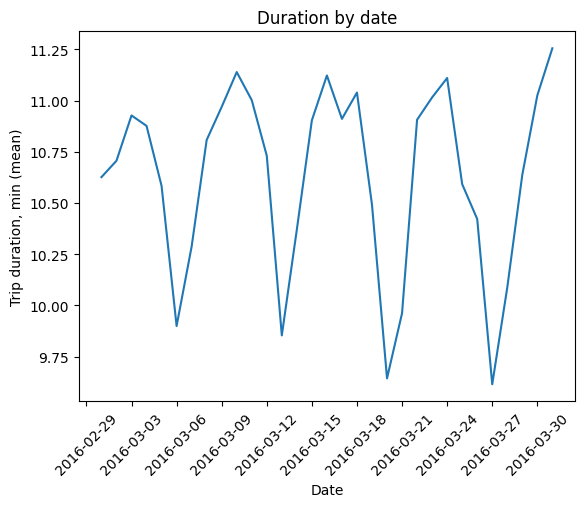

In [ ]:
import matplotlib.dates as mdates
ax = dur_hist.plot.line(
    x='date_of_trip',
    title='Duration by date',
    xlabel='Date', ylabel='Trip duration, min (mean)',
    color='skyblue'
)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Метки каждые 3 дня
plt.xticks(rotation=45)  # Поворот меток оси X для удобства
ax.legend().remove() # Удаление легенды

plt.show()



Построим график для просмотра среднего расстояния поездки

In [ ]:
dist_hist = (
    data_df
    #.withColumn('hist', (df['trip_duration'] / 1000).astype(IntegerType()))
    .groupBy('date_of_trip').mean('trip_distance').orderBy('date_of_trip')
    #.withColumnRenamed('hist', 'trip_duration')
    .toPandas()
)

На графике видно, что средняя дистанция поездки так же как и время циклична. Это связано с тем, что по выходным люди ездят отдыхать чуть дальше, чем по будням на работу.

(array([16860., 16863., 16866., 16869., 16872., 16875., 16878., 16881.,
        16884., 16887., 16890.]),
 [Text(16860.0, 0, '2016-02-29'),
  Text(16863.0, 0, '2016-03-03'),
  Text(16866.0, 0, '2016-03-06'),
  Text(16869.0, 0, '2016-03-09'),
  Text(16872.0, 0, '2016-03-12'),
  Text(16875.0, 0, '2016-03-15'),
  Text(16878.0, 0, '2016-03-18'),
  Text(16881.0, 0, '2016-03-21'),
  Text(16884.0, 0, '2016-03-24'),
  Text(16887.0, 0, '2016-03-27'),
  Text(16890.0, 0, '2016-03-30')])

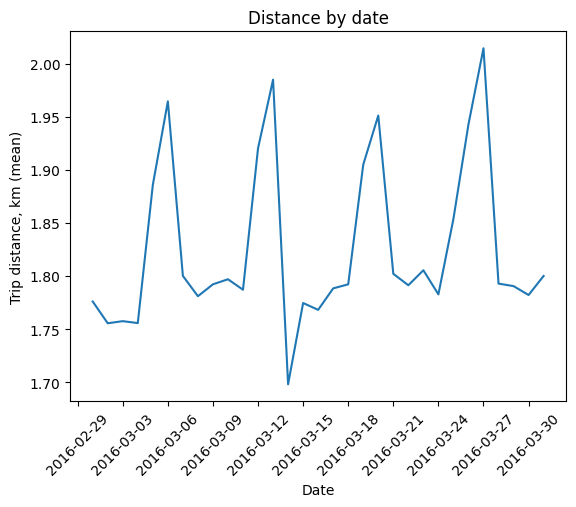

In [ ]:
import matplotlib.dates as mdates
ax = dist_hist.plot.line(
    x='date_of_trip',
    title='Distance by date',
    xlabel='Date', ylabel='Trip distance, km (mean)',
    color='skyblue'
)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Метки каждые 3 дня
plt.xticks(rotation=45)  # Поворот меток оси X для удобства
ax.legend().remove()

plt.show()

Теперь посмотрим на количество поездок по датам

In [ ]:
count_trip_hist = (
    data_df
    #.withColumn('hist', (df['trip_duration'] / 1000).astype(IntegerType()))
    .groupBy('date_of_trip').count().orderBy('date_of_trip')
    #.withColumnRenamed('hist', 'trip_duration')
    .toPandas()
)

Можем заметить, что по пятницам и выходным количество поездок чуть больше, чем по будням. Это видно по 12 19 25 числам месяца

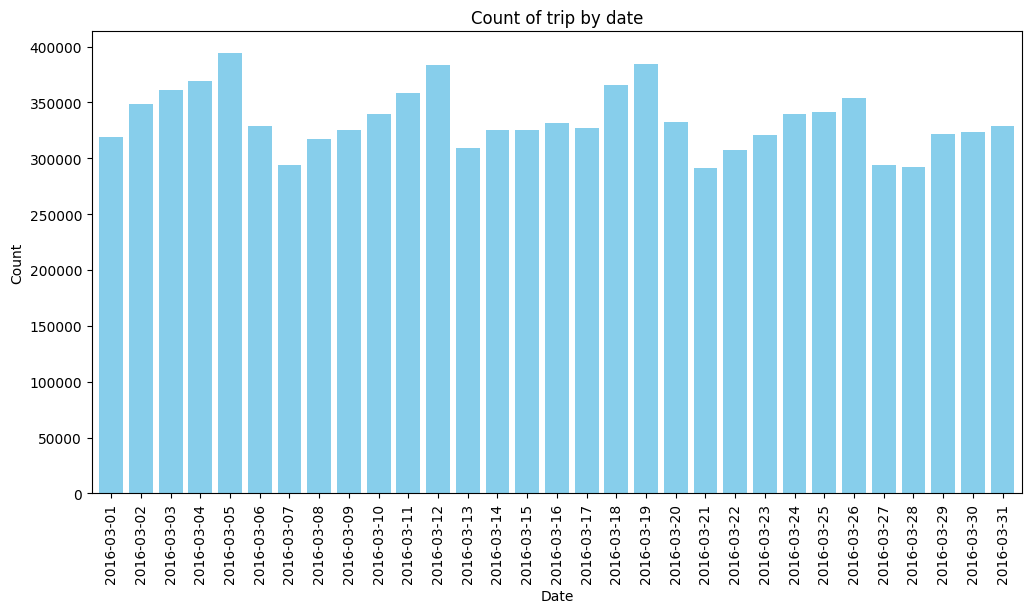

In [ ]:
ax = count_trip_hist.plot.bar(
    figsize=(12, 6),
    x='date_of_trip',
    align='center',
    width=0.8,
    title='Count of trip by date',
    xlabel='Date', ylabel='Count',
    color='skyblue'
)

ax.legend().remove()

Построим график для просмотра суммы за поездку по датам

In [ ]:
amount_hist = (
    data_df
    .groupBy('date_of_trip').mean('total_amount').orderBy('date_of_trip')
    .toPandas()
)

На графике видно, что стоимость поездок в пятницу-субботу выходит чуть выше, чем в остальные дни.

(array([16860., 16863., 16866., 16869., 16872., 16875., 16878., 16881.,
        16884., 16887., 16890.]),
 [Text(16860.0, 0, '2016-02-29'),
  Text(16863.0, 0, '2016-03-03'),
  Text(16866.0, 0, '2016-03-06'),
  Text(16869.0, 0, '2016-03-09'),
  Text(16872.0, 0, '2016-03-12'),
  Text(16875.0, 0, '2016-03-15'),
  Text(16878.0, 0, '2016-03-18'),
  Text(16881.0, 0, '2016-03-21'),
  Text(16884.0, 0, '2016-03-24'),
  Text(16887.0, 0, '2016-03-27'),
  Text(16890.0, 0, '2016-03-30')])

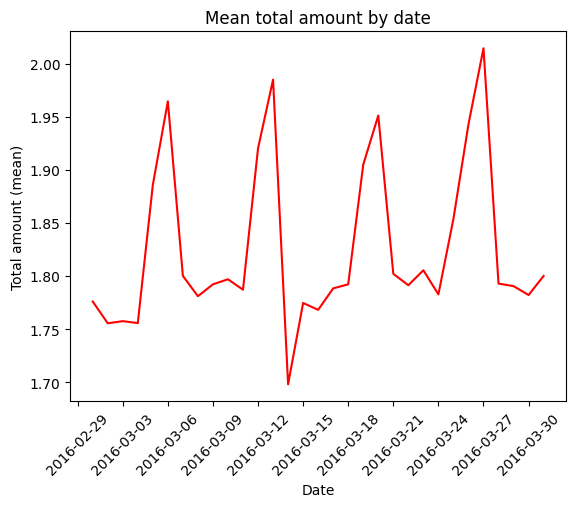

In [ ]:
ax = dist_hist.plot.line(
    x='date_of_trip',
    title='Mean total amount by date',
    xlabel='Date', ylabel='Total amount (mean)',
    color='red'
)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)
ax.legend().remove()

Сгруппируем по типу оплаты поездки (всего в таблице этих типов 4, что видно из первоначальной статистики)

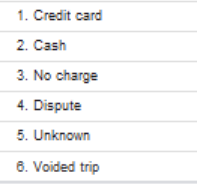

In [ ]:
#with_hist = (
#    data_df.withColumn('hist', (data_df.distance / 1000).astype(IntegerType()))
 #   .groupBy('date_of_trip').mean('trip_duration').orderBy('date_of_trip')
 #   #.withColumnRenamed('hist', 'trip_duration')
#    .toPandas()
#)

credit_card = data_df.where(data_df.payment_type == '1').groupBy('date_of_trip').count().orderBy('date_of_trip').withColumnRenamed('count', 'credit_card')
cash = data_df.where(data_df.payment_type == '2').groupBy('date_of_trip').count().orderBy('date_of_trip').withColumnRenamed('count', 'cash')
no_charge = data_df.where(data_df.payment_type == '3').groupBy('date_of_trip').count().orderBy('date_of_trip').withColumnRenamed('count', 'no_charge')
dispute = data_df.where(data_df.payment_type == '4').groupBy('date_of_trip').count().orderBy('date_of_trip').withColumnRenamed('count', 'dispute')


dist_hist_2 = cash.join(credit_card, ['date_of_trip'], 'full').join(no_charge, ['date_of_trip'], 'full').join(dispute, ['date_of_trip'], 'full').fillna(0).orderBy('date_of_trip').toPandas()

Из графика видно, что больше всего клиентов оплачивают поездки с помощью кредитной карты.

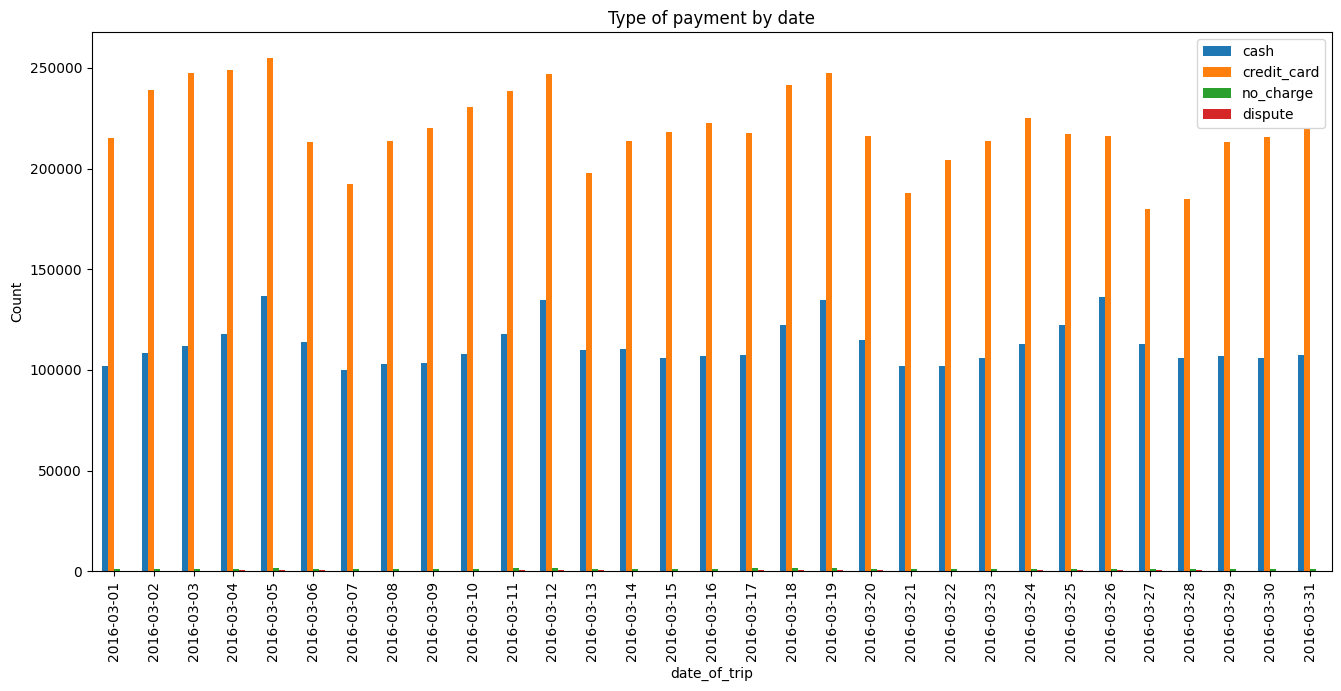

In [ ]:
ax = dist_hist_2.plot.bar(
    x='date_of_trip', align='center', width=0.6,
    title='Type of payment by date',
    xlabel='date_of_trip', ylabel='Count',
    figsize=(16, 7),
)

# UDF

In [139]:
#создадим функцию для расчета стоимости поездки на пассажира
def cost_per_passenger(total_amount, passenger_count):
    if passenger_count == 0:
        return None
    return total_amount / passenger_count

cost_per_passenger_udf = udf(cost_per_passenger, DoubleType())
df_with_cost = data_df.withColumn('cost_per_passenger', cost_per_passenger_udf(col("total_amount"), col('passenger_count')))

df_with_cost.limit(10).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,date_of_trip,cost_per_passenger
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,2.50,-73.976746,40.765152,1,N,-74.004265,...,9.0,0.5,0.5,2.05,0.0,0.3,12.35,7.916667,2016-03-01,12.35
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,2.90,-73.983482,40.767925,1,N,-74.005943,...,11.0,0.5,0.5,3.05,0.0,0.3,15.35,11.100000,2016-03-01,15.35
2,1,2016-03-01 00:00:01,2016-03-01 00:05:00,1,0.70,-73.958221,40.764641,1,N,-73.967896,...,5.5,0.5,0.5,2.00,0.0,0.3,8.80,4.983333,2016-03-01,8.80
3,2,2016-03-01 00:00:01,2016-03-01 00:02:03,2,0.54,-73.988426,40.764160,1,N,-73.992393,...,4.0,0.5,0.5,0.00,0.0,0.3,5.30,2.033333,2016-03-01,2.65
4,1,2016-03-01 00:00:02,2016-03-01 00:07:49,1,1.70,-73.969818,40.797428,1,N,-73.943771,...,8.0,0.5,0.5,0.00,0.0,0.3,9.30,7.783333,2016-03-01,9.30
5,1,2016-03-01 00:00:02,2016-03-01 00:03:05,1,1.10,-73.953804,40.788128,1,N,-73.971550,...,5.5,0.5,0.5,2.20,0.0,0.3,9.00,3.050000,2016-03-01,9.00
6,2,2016-03-01 00:00:02,2016-03-01 00:09:32,1,2.10,-73.976089,40.752171,1,N,-73.987450,...,9.0,0.5,0.5,2.06,0.0,0.3,12.36,9.500000,2016-03-01,12.36
7,2,2016-03-01 00:00:02,2016-03-01 00:08:24,1,2.00,-74.006729,40.730717,1,N,-74.017044,...,8.5,0.5,0.5,2.00,0.0,0.3,11.80,8.366667,2016-03-01,11.80
8,1,2016-03-01 00:00:03,2016-03-01 00:09:23,1,3.20,-74.006615,40.716621,1,N,-73.990105,...,11.0,0.5,0.5,0.00,0.0,0.3,12.30,9.333333,2016-03-01,12.30
9,2,2016-03-01 00:00:03,2016-03-01 00:08:34,1,1.59,-73.982269,40.770618,1,N,-73.968742,...,8.0,0.5,0.5,1.86,0.0,0.3,11.16,8.516667,2016-03-01,11.16


## Заключение

Посмотрим на финальный датасет и типы данных

In [ ]:
data_df.limit(5).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,date_of_trip
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,2.50,-73.976746,40.765152,1,N,-74.004265,...,1,9.0,0.5,0.5,2.05,0.0,0.3,12.35,7.916667,2016-03-01
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,2.90,-73.983482,40.767925,1,N,-74.005943,...,1,11.0,0.5,0.5,3.05,0.0,0.3,15.35,11.100000,2016-03-01
2,1,2016-03-01 00:00:01,2016-03-01 00:05:00,1,0.70,-73.958221,40.764641,1,N,-73.967896,...,1,5.5,0.5,0.5,2.00,0.0,0.3,8.80,4.983333,2016-03-01
3,2,2016-03-01 00:00:01,2016-03-01 00:02:03,2,0.54,-73.988426,40.764160,1,N,-73.992393,...,2,4.0,0.5,0.5,0.00,0.0,0.3,5.30,2.033333,2016-03-01
4,1,2016-03-01 00:00:02,2016-03-01 00:07:49,1,1.70,-73.969818,40.797428,1,N,-73.943771,...,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30,7.783333,2016-03-01


In [ ]:
pd.DataFrame(data_df.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,VendorID,int
1,tpep_pickup_datetime,timestamp
2,tpep_dropoff_datetime,timestamp
3,passenger_count,int
4,trip_distance,double
5,pickup_longitude,double
6,pickup_latitude,double
7,RatecodeID,int
8,store_and_fwd_flag,string
9,dropoff_longitude,double


Сохраним полученный датасет для дальнейшего использования

In [ ]:
data_df.write.mode("overwrite").option("header", True).csv("data/data_df.csv")

Завершим сессию спарк

In [ ]:
spark.stop()